In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import time

import torch
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from easydict import EasyDict

sys.path.append(os.path.abspath('..'))

from models import get_flow_model
from models.constraints import InitialCondition, BoundaryCondition
from datasets import StokesDataset

# ECI Sampling

In this notebook, we demonstrate how to use the ECI sampling method as a gradient-free zero-shot framework for pre-trained FFMs to generate samples with constraints. We use the Stokes problem dataset as an example and test with two different settings for fixing the initial condition (IC) and boundary condition (BC), respectively. We first load the dataset for pre-training FFM and visualize its per-pixel statistics.

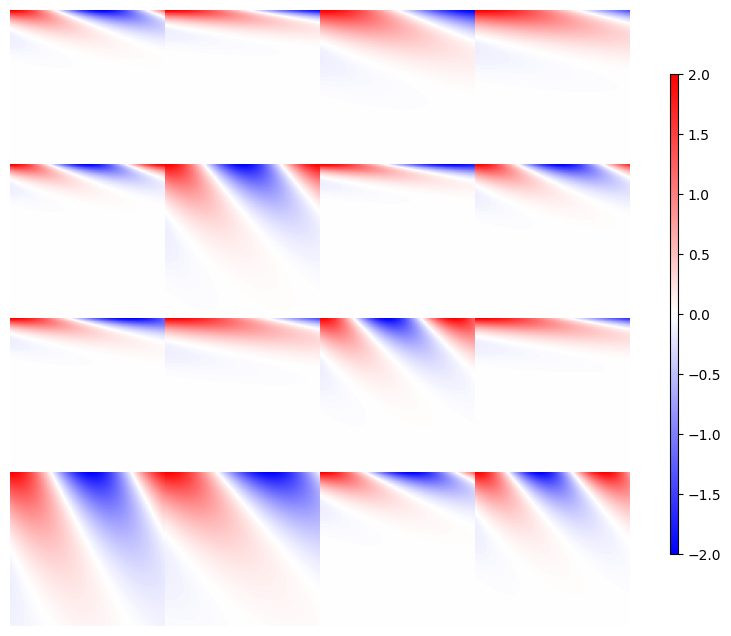

In [3]:
def plot_grid(data, nrow=8, vmin=-2., vmax=2., cmap='bwr'):
    x = data.detach().cpu()
    fig, axes = plt.subplots(nrow, x.size(0) // nrow, figsize=(8, 8))
    fig.subplots_adjust(hspace=0., wspace=0.)
    if x.size(0) == 1:
        img = axes.imshow(x[0], cmap=cmap, aspect='auto', vmin=vmin, vmax=vmax)
        axes.axis('off')
    else:
        for i, ax in enumerate(axes.flat):
            img = ax.imshow(x[i], cmap=cmap, aspect='auto', vmin=vmin, vmax=vmax)
            ax.axis('off')
    cax = fig.add_axes([0.95, 0.2, 0.01, 0.6])
    fig.colorbar(img, cax=cax)
    plt.show()


test_set = StokesDataset('test', nx=100, nt=100, k_range=(2., 20.), freq_range=(2., 8.))
test_loader = DataLoader(test_set, batch_size=512, shuffle=False)
data = next(iter(test_loader))
plot_grid(data[:16], 4, vmin=-2, vmax=2)

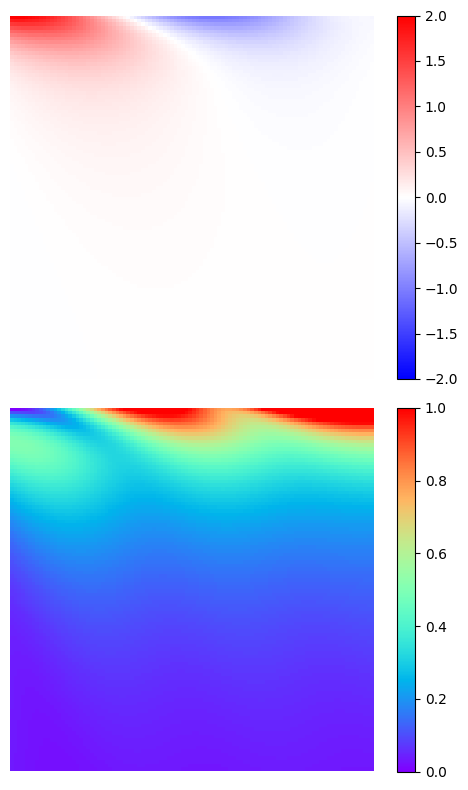

In [4]:
def plot_stats(data, vmin=-2, vmax=2, stdmax=1, cmap='bwr'):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 8))
    fig.subplots_adjust(hspace=0., wspace=0.)
    im1 = ax1.imshow(data.mean(0), cmap=cmap, aspect='equal', vmin=vmin, vmax=vmax)
    ax1.axis('off')
    im2 = ax2.imshow(data.std(0), cmap='rainbow', aspect='equal', vmin=0, vmax=stdmax)
    ax2.axis('off')
    fig.colorbar(im1)
    fig.colorbar(im2)
    plt.tight_layout()
    plt.show()


plot_stats(data, vmin=-2, vmax=2, stdmax=1)

In [5]:
device = 'cuda:0'
ckpt_path = '../logs/stokes/20000.pt'
ckpt = torch.load(ckpt_path, map_location=device)
config = EasyDict(ckpt['config'])
print(config)
model = get_flow_model(config.model, config.encoder).to(device)
model.load_state_dict(ckpt['model'])
model.eval()
print('Complete!')

{'train': {'seed': 42, 'max_iter': 20000, 'batch_size': 256, 'log_freq': 50, 'val_freq': 200, 'save_freq': 5000, 'max_grad_norm': 100.0, 'valid_max_batch': 32, 'optimizer': {'type': 'adam', 'lr': 0.0003, 'weight_decay': 0.0, 'beta1': 0.9, 'beta2': 0.999}, 'scheduler': {'type': 'plateau', 'factor': 0.5, 'patience': 10, 'min_lr': 0.0001}}, 'datasets': {'type': 'stokes', 'nx': 100, 'nt': 100, 'visc_range': [0.01, 1.0], 'k_range': [2.0, 20.0], 'freq_range': [2.0, 8.0], 't_range': [0.0, 1.0], 'amp': 2.0, 'train': {'n_data': 5000}, 'test': {'n_data': 1000}}, 'model': {'kernel_length': 0.001, 'kernel_variance': 1.0}, 'encoder': {'type': 'fno', 'n_modes': [32, 32], 'emb_channels': 32, 'hidden_channels': 64, 'proj_channels': 256, 'n_layers': 4}, 'n_sample': 2, 'n_eval': 1, 'sample_dims': [100, 100]}
Complete!


## Unconditional generation

We first demonstrate the unconditional generation of the Stokes problem dataset using the pre-trained FFM.

In [6]:
def calculate_metrics(ref, gen):
    stats = {
        'mean': [ref.mean(0), gen.mean(0)],
        'std': [ref.std(0), gen.std(0)],
    }
    for s, (ref_s, gen_s) in stats.items():
        mse = (ref_s - gen_s).pow(2).mean()
        print(f'{s} MSE: {mse:.6f}')

Time: 16.3330 s
mean MSE: 0.003521
std MSE: 0.001924


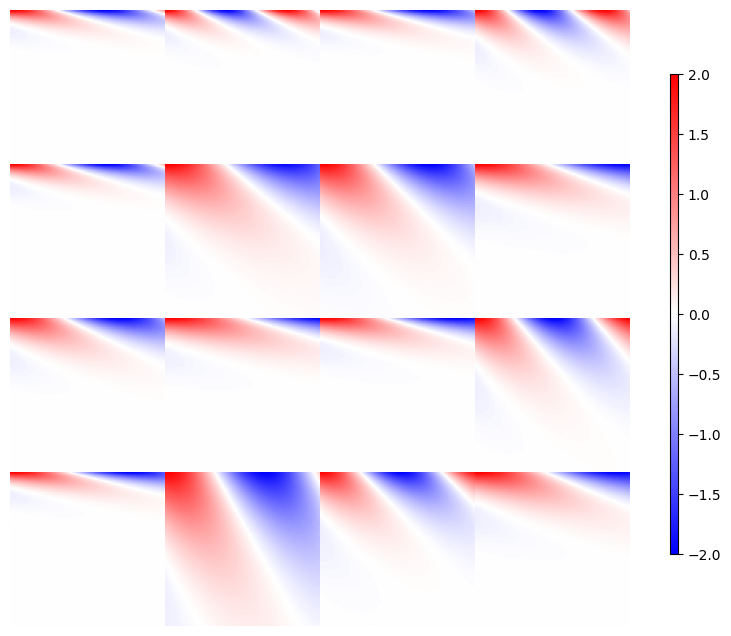

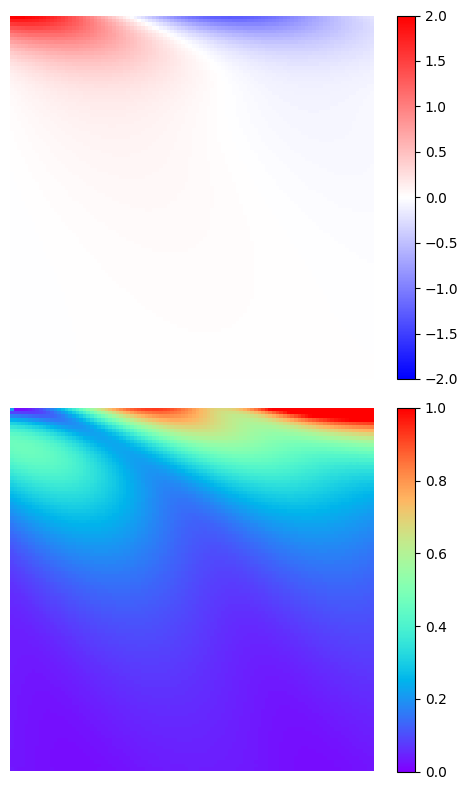

In [7]:
batch_size = 256
with torch.no_grad():
    start = time.time()
    gen = model.sample(batch_size, 1, (100, 100), device).detach().cpu()
    end = time.time()
    print(f'Time: {end - start:.4f} s')
calculate_metrics(data, gen)
plot_grid(gen[:16], 4, vmin=-2, vmax=2)
plot_stats(gen, vmin=-2, vmax=2, stdmax=1)

## Constrained generation with IC fixed

We fix the IC with $k=5$ and load the new dataset for testing. We then generate samples with the fixed IC using the ECI sampling method.

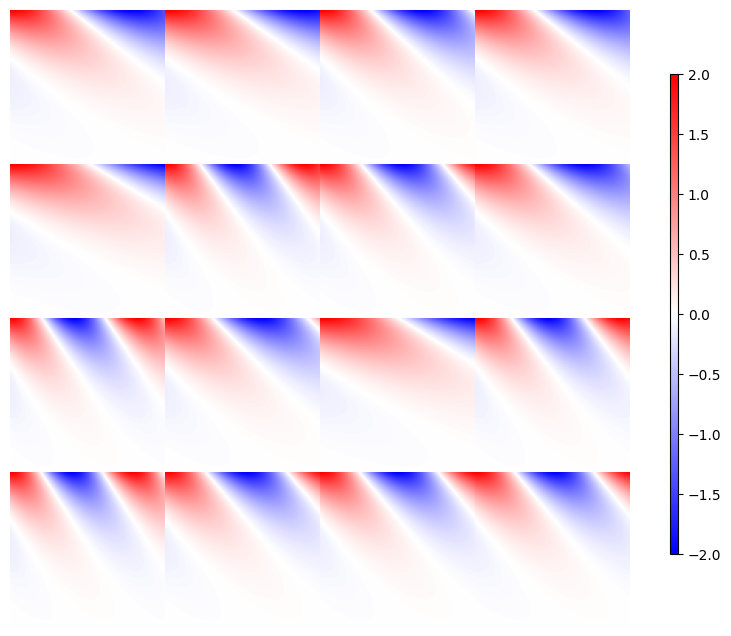

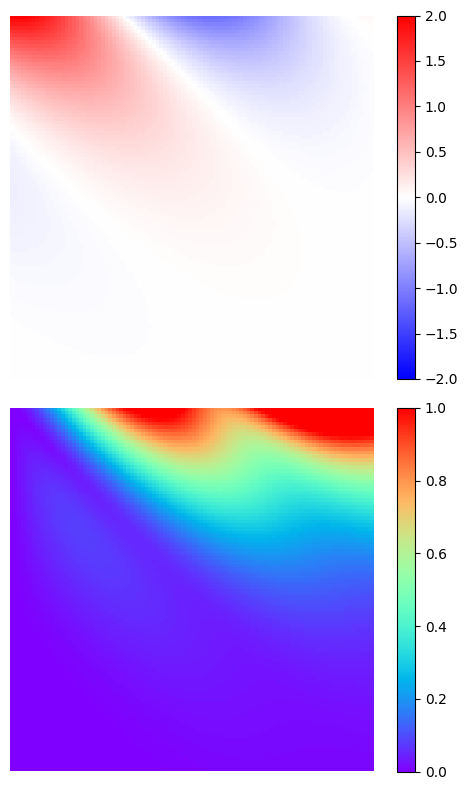

In [8]:
test_set = StokesDataset('test', nx=100, nt=100, k_range=(5., 5.), freq_range=(2., 8.))
test_loader = DataLoader(test_set, batch_size=512, shuffle=False)
data = next(iter(test_loader))
plot_grid(data[:16], 4, vmin=-2, vmax=2)
plot_stats(data, vmin=-2, vmax=2, stdmax=1)

ECI Sampling: 100%|██████████| 200/200 [01:22<00:00,  2.43it/s]


Time: 83.0344 s
mean MSE: 0.001893
std MSE: 0.002248


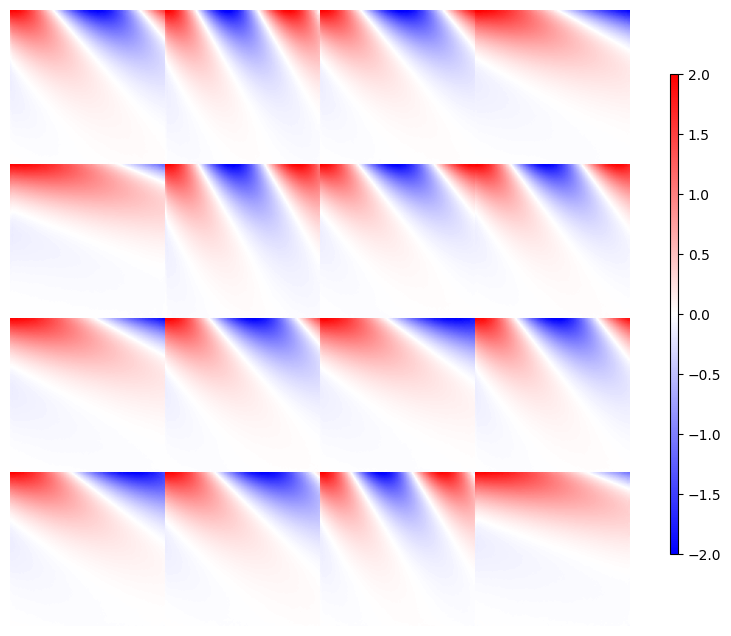

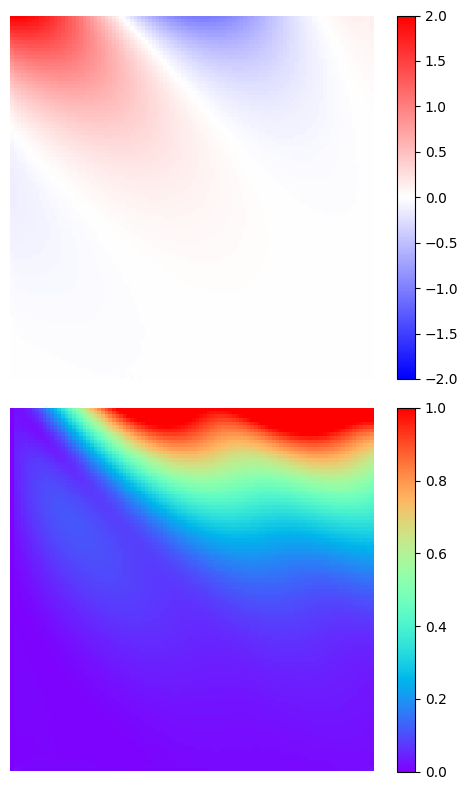

In [9]:
constraint = InitialCondition(data[:1, :, 0]).to(device)
batch_size = 256
with torch.no_grad():
    start = time.time()
    gen_ic = model.eci_sample(
        batch_size, n_step=200, n_mix=5, resample_step=None,
        dims=(100, 100), device=device, constraint=constraint
    ).detach().cpu()
    end = time.time()
    print(f'Time: {end - start:.4f} s')
calculate_metrics(data, gen_ic)
plot_grid(gen_ic[:16], 4, vmin=-2, vmax=2)
plot_stats(gen_ic, vmin=-2, vmax=2, stdmax=1)

## Constrained generation with BC fixed

We fix the BC with $\omega=6$ and load the new dataset for testing. We then generate samples with the fixed BC using the ECI sampling method.

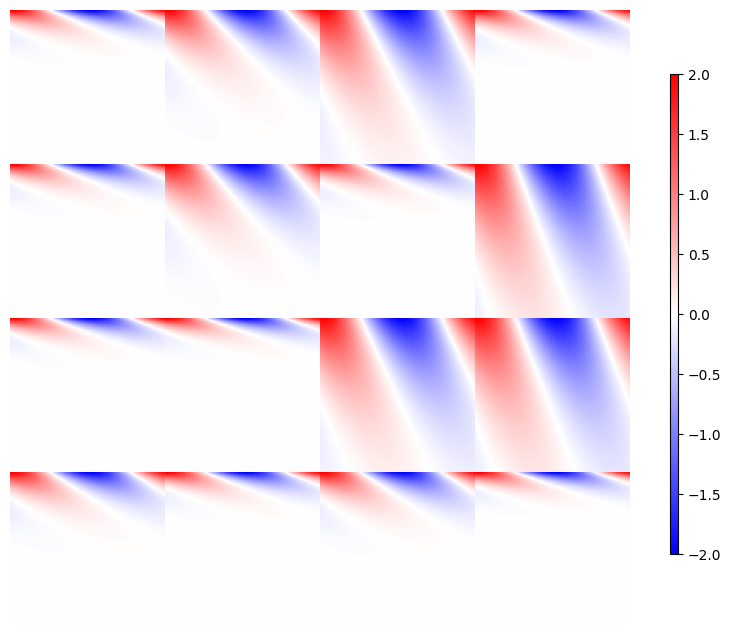

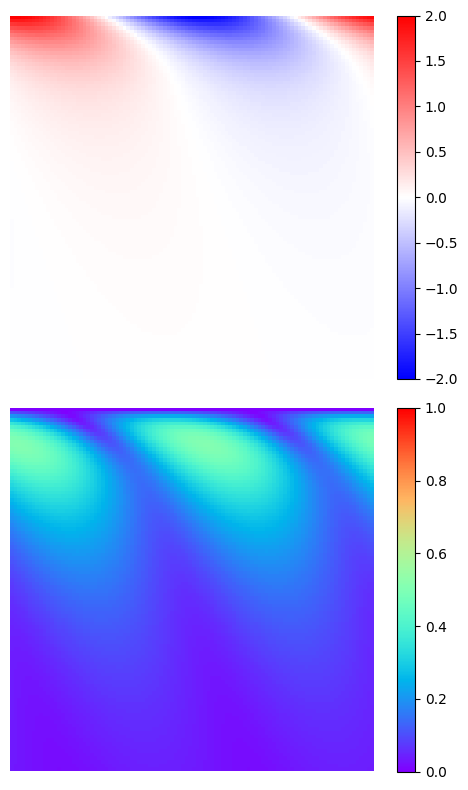

In [10]:
test_set = StokesDataset('test', nx=100, nt=100, k_range=(2., 20.), freq_range=(6., 6.))
test_loader = DataLoader(test_set, batch_size=512, shuffle=False)
data = next(iter(test_loader))
plot_grid(data[:16], 4, vmin=-2, vmax=2)
plot_stats(data, vmin=-2, vmax=2, stdmax=1)

ECI Sampling: 100%|██████████| 200/200 [00:18<00:00, 10.64it/s]


Time: 18.9423 s
mean MSE: 0.000369
std MSE: 0.000110


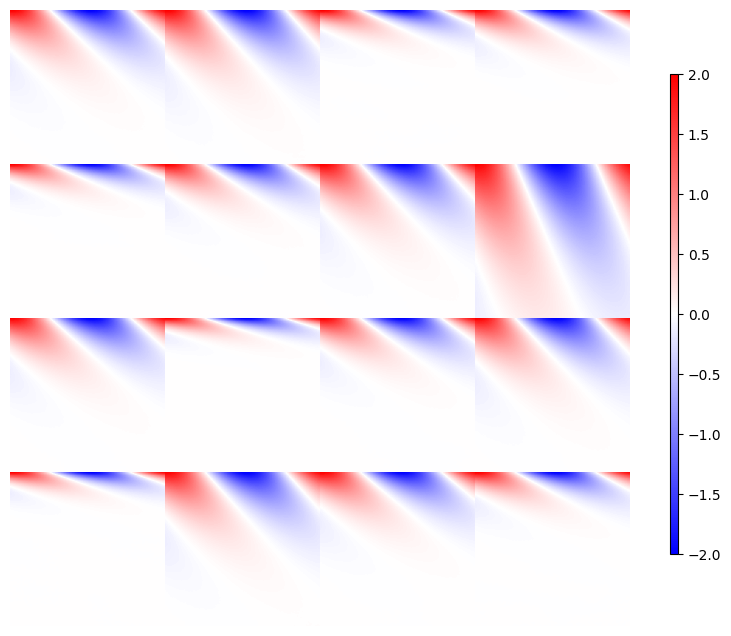

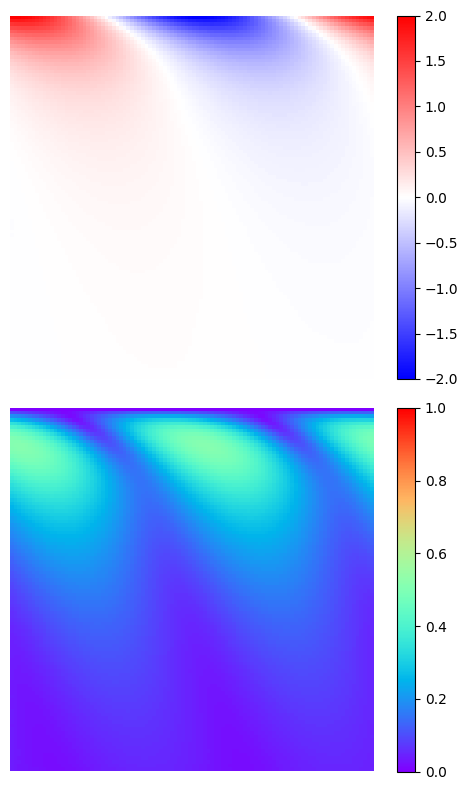

In [11]:
constraint = BoundaryCondition(data[:1, 0, :]).to(device)
batch_size = 256
with torch.no_grad():
    start = time.time()
    gen_bc = model.eci_sample(
        batch_size, n_step=200, n_mix=1, resample_step=5,
        dims=(100, 100), device=device, constraint=constraint
    ).detach().cpu()
    end = time.time()
    print(f'Time: {end - start:.4f} s')
calculate_metrics(data, gen_bc)
plot_grid(gen_bc[:16], 4, vmin=-2, vmax=2)
plot_stats(gen_bc, vmin=-2, vmax=2, stdmax=1)